<a href="https://colab.research.google.com/github/Jaeya/pytorch/blob/main/04_pytorch_image_recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

경사하강법을 통해서 왜곡된 이미지를
원래 이미지로 변환하는 예제

[준비]<br/>
1) 오염된 이미지 = weird_function(정상이미지)<br/>
2) pickle로 오염된 이미지 -> broken_image_t.p 저장<br/>
[노이즈 이미지로 원본 이미지를 찾아가기]<br/>
3) broken_image_t.p를 읽어 들임<br/>
4) randn으로 noise 이미지를 만듬<br/>
5) new 오염 이미지 = weird_function(noise 이미지)<br/>
6) loss = new오염이미지 - 오염이미지<br/>
7) noise이미지가 loss에 미치는 영향(기울기)을 구한다<br/>
8) new오염이미지 - 오염이지미가 0에 가까워지도록 학습<br/>
9) noise이미지는 원본오염이미지가 werid_function을 거치기전과 유사하게 변화<br/>
10) loss가 아주 적게 나오는 것을 확인했으면 noise이미지를 출력한다<br/>


In [1]:
import torch

In [2]:
import pickle

In [14]:
import matplotlib.pyplot as plt

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


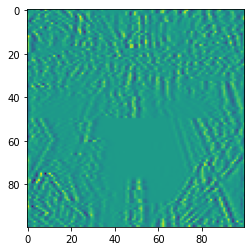

In [18]:
# 이미지를 pickle로 파일에 저장해놓은 것을 읽어들인다
# 10000개의 1차원 tensor이므로 화면에 출력하기위해 view(100,100)로 2차원 (100,100)으로 변환후 출력

image_path = '/content/drive/MyDrive/Colab Notebooks/broken_image_t.p'
broken_image =  torch.FloatTensor( pickle.load(open(image_path, 'rb'),encoding='latin1' ) )
plt.imshow(broken_image.view(100,100))

In [19]:
# x에 들어온 값을 기이하게 변환하는 함수(해석할 필요 x)
def weird_function(x, n_iter=5):
    h = x    
    filt = torch.tensor([-1./3, 1./3, -1./3])
    for i in range(n_iter):
        zero_tensor = torch.tensor([1.0*0])
        h_l = torch.cat( (zero_tensor, h[:-1]), 0)
        h_r = torch.cat((h[1:], zero_tensor), 0 )
        h = filt[0] * h + filt[2] * h_l + filt[1] * h_r
        if i % 2 == 0:
            h = torch.cat( (h[h.shape[0]//2:],h[:h.shape[0]//2]), 0  )
    return h


In [20]:
# 2개 입력 tensor의 차이를 반환하는 함수(얼마나 다르냐)
def distance_loss(hypothesis, broken_image):
  return torch.dist(hypothesis, broken_image)

In [25]:
# 정규분표 난수를 이용해 float타입 10000개를 가지는 tensor를 생성하라
random_tensor = torch.randn(10000, dtype = torch.float)
print(random_tensor.size())
print(random_tensor.ndimension())

# 경사하강법
# : weight(가중치)가 error에 미치는 영향(기울기)을 구해서
# : 조금씩 기울기의 반대방향으로 이동해서 error를 줄여나가는 것
# 기존 기울기 - 학습률*기울기 값
lr = 0.8

torch.Size([10000])
1


In [28]:

for i in range(0,20000):
  # random_tensor가 연쇄함수를 통해서
  # 최종요소에 미치는 기울기를 구하고 싶다
  # loss = z(y(x))
  random_tensor.requires_grad_(True)
  hypothesis = weird_function(random_tensor)
  loss = distance_loss(hypothesis, broken_image)
  loss.backward() # random_tensor가 loss에 미치는 영향(기울기)를 구한다
  with torch.no_grad(): # torch에서 제공하는 경사하강법을 안쓰겠다.
    
    # 직접 우리가 경사하강법을 진행한다
    # 도출 이미지 = noise 이미지 - 학습률 * noise이미지의 기울기
    # loss가 줄어드는 방향으로 random_tensor의 값이 변화한다
    # hypothesis가 broken_image를 점점 닮아간다.
    random_tensor = random_tensor - lr*random_tensor.grad
  if i % 1000 == 0:
    print('Loss at {} = {}'.format(i, loss.item()))

Loss at 0 = 0.021166913211345673
Loss at 1000 = 0.021167555823922157
Loss at 2000 = 0.021167663857340813
Loss at 3000 = 0.021168187260627747
Loss at 4000 = 0.02116691693663597
Loss at 5000 = 0.02116542123258114
Loss at 6000 = 0.021165059879422188
Loss at 7000 = 0.021164417266845703
Loss at 8000 = 0.02116476185619831
Loss at 9000 = 0.02116565778851509
Loss at 10000 = 0.021163813769817352
Loss at 11000 = 0.021164294332265854
Loss at 12000 = 0.021164920181035995
Loss at 13000 = 0.021166155114769936
Loss at 14000 = 0.02116772159934044
Loss at 15000 = 0.021167587488889694
Loss at 16000 = 0.021167702972888947
Loss at 17000 = 0.021167555823922157
Loss at 18000 = 0.021167093887925148
Loss at 19000 = 0.021167224273085594


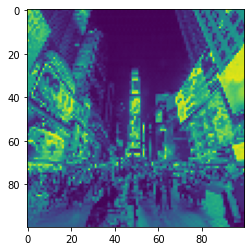

In [27]:
plt.imshow(random_tensor.view(100,100).data)